In [1]:
import  os
import glob as glob
import datetime as dt
import numpy as np
import pandas as pd
import csv
from bs4 import BeautifulSoup
import seaborn as sns
sns.set_style("darkgrid")
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.patches import Patch
plt.style.use('fivethirtyeight')

### Introduction

##### This analysis is based on a dataset from Brazil containing about 100k medical appointments. The goal is to find out how patients respond to their appointment and to also investigate on factors that influence the various responses.

##### Neighborhood indicates where the hospital is located
##### Scholarship indicates if the patient is enrolled in Brasilian welfare or not.
##### 1 stands for something being present while
##### 0 stands for it's absence
##### For the No-show column, No stands for a show up for the appointment while yes stands for absence at the appointment.

### Questions

##### 1.	How many patients were living with different disease conditions and which is the most common?
##### 2.	What’s the relative number of male patients compared to females?
##### 3.	What role does the Scholarship and SMS notification play in the responses of patients to return for appointments? Does it improve responses?
##### 4.	Do Males tend to neglect appointments more than females?

#### Loading the No Show Appointment Data

In [2]:
os.chdir("C:/Users/gameon/Downloads/")

In [3]:
Data = pd.read_csv("noshowappointments-kagglev2-may-2016.csv")

#### Viewing the Data

In [4]:
Data.shape

(110527, 14)

In [5]:
Data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   PatientId       110527 non-null  float64
 1   AppointmentID   110527 non-null  int64  
 2   Gender          110527 non-null  object 
 3   ScheduledDay    110527 non-null  object 
 4   AppointmentDay  110527 non-null  object 
 5   Age             110527 non-null  int64  
 6   Neighbourhood   110527 non-null  object 
 7   Scholarship     110527 non-null  int64  
 8   Hipertension    110527 non-null  int64  
 9   Diabetes        110527 non-null  int64  
 10  Alcoholism      110527 non-null  int64  
 11  Handcap         110527 non-null  int64  
 12  SMS_received    110527 non-null  int64  
 13  No-show         110527 non-null  object 
dtypes: float64(1), int64(8), object(5)
memory usage: 9.7+ MB


In [6]:
Data.dtypes

PatientId         float64
AppointmentID       int64
Gender             object
ScheduledDay       object
AppointmentDay     object
Age                 int64
Neighbourhood      object
Scholarship         int64
Hipertension        int64
Diabetes            int64
Alcoholism          int64
Handcap             int64
SMS_received        int64
No-show            object
dtype: object

In [7]:
Data.columns

Index(['PatientId', 'AppointmentID', 'Gender', 'ScheduledDay',
       'AppointmentDay', 'Age', 'Neighbourhood', 'Scholarship', 'Hipertension',
       'Diabetes', 'Alcoholism', 'Handcap', 'SMS_received', 'No-show'],
      dtype='object')

In [8]:
Data.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


### Data Wrangling

##### Checking for Missing Data to ensure a balanced data

In [9]:
Data.isnull().sum()

PatientId         0
AppointmentID     0
Gender            0
ScheduledDay      0
AppointmentDay    0
Age               0
Neighbourhood     0
Scholarship       0
Hipertension      0
Diabetes          0
Alcoholism        0
Handcap           0
SMS_received      0
No-show           0
dtype: int64

###### Checking for data duplicates to ensure the data is balanced

In [10]:
Data.duplicated().sum()

0

##### Renaming columns that have errors in spelling for ease of use

In [11]:
Data = Data.rename(columns = {'Hipertension' : 'Hypertension', 'Handcap' : 'Handicap', 'No-show' : 'No Show', 'SMS_received' : 'SMS-Received'})

##### Changing the data type for the Appointment and Scheduled Days to Datetime to reflect the the dates in the right format

In [12]:
Data[['ScheduledDay', 'AppointmentDay']] = Data[['ScheduledDay', 'AppointmentDay']].apply(pd.to_datetime)
Data.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMS-Received,No Show
0,2.987250e+13,5642903,F,2016-04-29 18:38:08+00:00,2016-04-29 00:00:00+00:00,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29 16:08:27+00:00,2016-04-29 00:00:00+00:00,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29 16:19:04+00:00,2016-04-29 00:00:00+00:00,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29 17:29:31+00:00,2016-04-29 00:00:00+00:00,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29 16:07:23+00:00,2016-04-29 00:00:00+00:00,56,JARDIM DA PENHA,0,1,1,0,0,0,No


##### Checking the statistical picture of the data for outliers

In [13]:
Data.describe()

,PatientId,AppointmentID,Age,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMS-Received
count,1.105270e+05,1.105270e+05,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000
mean,1.474963e+14,5.675305e+06,37.088874,0.098266,0.197246,0.071865,0.030400,0.022248,0.321026
std,2.560949e+14,7.129575e+04,23.110205,0.297675,0.397921,0.258265,0.171686,0.161543,0.466873
min,3.921784e+04,5.030230e+06,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.172614e+12,5.640286e+06,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.173184e+13,5.680573e+06,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,9.439172e+13,5.725524e+06,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,9.999816e+14,5.790484e+06,115.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000


##### Replacing the negative value in the Age column with zero (0)

In [14]:
Data.loc[Data['Age'] < 0, 'Age'] = 0
Data['Age'].describe()

count    110527.000000
mean         37.088883
std          23.110190
min           0.000000
25%          18.000000
50%          37.000000
75%          55.000000
max         115.000000
Name: Age, dtype: float64

### Exploratory Data Analysis

In [15]:
#Using a function for the figure size to avoid repititive coding
def my_function(x,y):
    return plt.figure(figsize=(x,y))

0    88726
1    21801
Name: Hypertension, dtype: int64


([<matplotlib.axis.XTick at 0xa91e100>, <matplotlib.axis.XTick at 0xa91e0e8>],
 [Text(0, 0, 'Hypertension'), Text(0, 0, 'No Hypertension')])

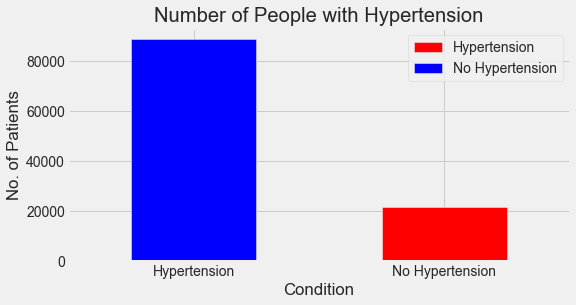

In [16]:
my_function(8,4)

print(Data['Hypertension'].value_counts())

colours={'Hypertension' : 'red', 'No Hypertension' : 'blue'}
Data['Hypertension'].value_counts().plot(kind='bar', color=['blue', 'red']).legend([ Patch (facecolor=colours['Hypertension']), Patch(facecolor=colours['No Hypertension'])], ['Hypertension', 'No Hypertension'])
plt.title('Number of People with Hypertension')
plt.xlabel('Condition')
plt.ylabel('No. of Patients')
plt.xticks([0, 1], ['Hypertension', 'No Hypertension'], rotation = 360)

##### Number of people with Diabetes

0    102584
1      7943
Name: Diabetes, dtype: int64


Text(0.5, 1.0, 'Number of people with Diabetes')

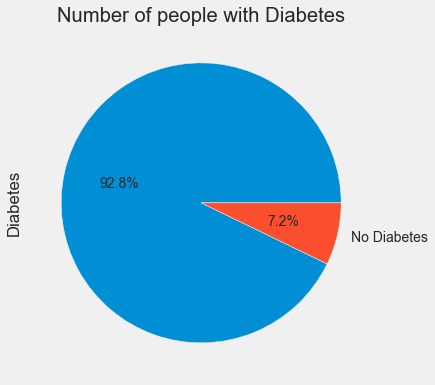

In [17]:
my_function(8,6)

print(Data['Diabetes'].value_counts())
labels = ['', 'No Diabetes']
Data['Diabetes'].value_counts().plot(kind='pie', labels=labels,autopct='%1.1f%%')
plt.title('Number of people with Diabetes')

##### Number of people with Disabilities

([<matplotlib.axis.XTick at 0xadfb3e8>, <matplotlib.axis.XTick at 0xadfb3d0>],
 [Text(0, 0, 'Disabled'), Text(0, 0, 'Not Disabled')])

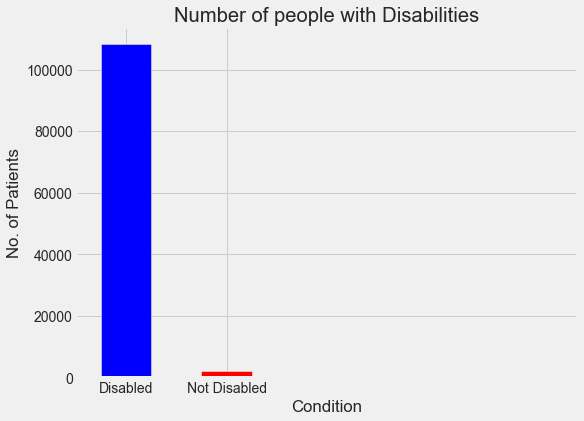

In [18]:
my_function(8,6)

Data['Handicap'].value_counts().plot(kind='bar', color=['blue', 'red'])
plt.title('Number of people with Disabilities')
plt.xlabel('Condition')
plt.ylabel('No. of Patients')
plt.xticks([0, 1], ['Disabled', 'Not Disabled'], rotation = 360)

#### From the data, we have more numbers of people living with Disabilities which means that majority of the patients have at least One Disability

In [19]:
Data['SMS-Received'].value_counts()

0    75045
1    35482
Name: SMS-Received, dtype: int64

##### Comparing the effect of the SMS Notifications on responses ofpatients

([<matplotlib.axis.XTick at 0xae2bfa0>, <matplotlib.axis.XTick at 0xae2bf88>],
 [Text(0, 0, 'Received SMS'), Text(0, 0, 'No SMS')])

<Figure size 576x432 with 0 Axes>

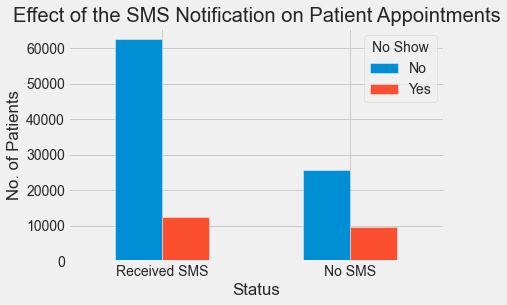

In [20]:
my_function(8,6)

CrosstabResult=pd.crosstab(index=Data['SMS-Received'],columns=Data['No Show'])

CrosstabResult.plot.bar()
plt.title('Effect of the SMS Notification on Patient Appointments')
plt.xlabel('Status')
plt.ylabel('No. of Patients')
plt.xticks([0, 1], ['Received SMS', 'No SMS'], rotation = 360)

#### More people with sms notifications appear to have responded compared to the set of people who did not. This shows that sending sms notifications plays a key role in whether or not they return for check ups and stopping this would negatively impact patient responses.

##### Comparing the number of those who received scholarship and responded

([<matplotlib.axis.XTick at 0xae81e20>, <matplotlib.axis.XTick at 0xae81e08>],
 [Text(0, 0, 'Scholarship'), Text(0, 0, 'No Scholarship')])

<Figure size 576x576 with 0 Axes>

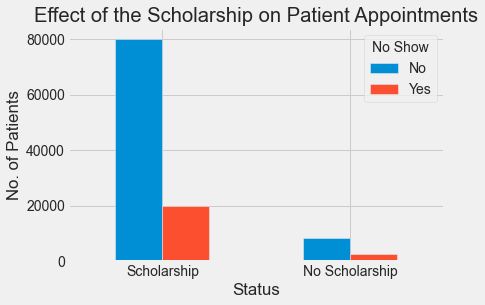

In [21]:
my_function(8,8)

CrosstabResult=pd.crosstab(index=Data['Scholarship'],columns=Data['No Show'])

CrosstabResult.plot.bar()
plt.title('Effect of the Scholarship on Patient Appointments')
plt.xlabel('Status')
plt.ylabel('No. of Patients')
plt.xticks([0, 1], ['Scholarship', 'No Scholarship'], rotation = 360)

##### Comparing the Genders with responses to the appointments

([<matplotlib.axis.XTick at 0xb84f3e8>, <matplotlib.axis.XTick at 0xb84f3d0>],
 [Text(0, 0, 'Males'), Text(0, 0, 'Females')])

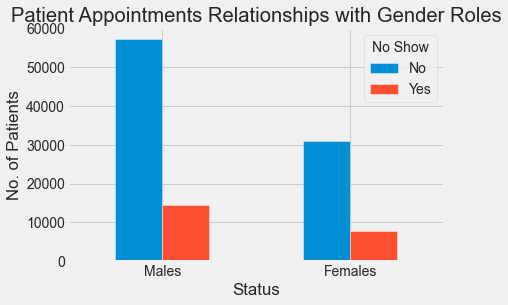

In [22]:
CrosstabResult=pd.crosstab(index=Data['Gender'],columns=Data['No Show'])

CrosstabResult.plot.bar()
plt.title('Patient Appointments Relationships with Gender Roles')
plt.xlabel('Status')
plt.ylabel('No. of Patients')
plt.xticks([0, 1], ['Males', 'Females'], rotation = 360)

#### It appears there were more female patients than male and more females likewise returned for their appointments.

### Conclusions

#### 1.From the exploratory data analysis, we're able to answer some of the posed questions. Hypertension is the most common disease condition of the three mentioned.
#### 2. There are more of female patients compared to the male and more of the female percentage show up for their appointment compared to the male.
#### 3. A higher percentage of those not on scholarship showed up for their appointment while a lesser ratio of those on scholarship showed up perhaps people value what they pay for, more than what is free.
#### 4. From the analysis, male patient neglect their appointment compared to the female
#### 5. It is recommended that the sms notifications should be strongly encouraged to improve responses from patients regardless of gender, scholarship or other demographic factors.

### Limitations

#### Time spent at the various hospital locations were not recorded. This might have helped to know if time spent at the hospital can serve as a motivation as to whether or not to show up. The interval spent at the hospital might have been a limitation factor for the patients especially the working class and aged.